# Stacking Models

Stacking is an ensemble learning method that combines multiple classification models to enhance predictive performance. It operates in two stages:

1. Train several base models on the dataset.
2. Use their predictions to train a meta-model, which learns to optimally integrate them.

This notebook implements and compares different stacking configurations using K-Nearest Neighbors, Decision Tree, Random Forest and Logistic regression as base models. Their predictions are used to train two different meta-models: Gaussian Naive Bayes and Logistic Regression. The performance of each stacking approach is evaluated using accuracy and confusion matrices to identify the most effective method.

### Importing modules

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay, roc_curve, auc

np.random.seed(42)

### Retrieval

The dataset is loaded from two sources:

- Cleaned Raw Data: The original training and testing sets after preprocessing.
- Cleaned Oversampled Data: A version of the dataset where oversampling techniques (e.g., SMOTE) have been applied to address class imbalance.

Using both datasets allows us to compare how models perform on naturally imbalanced data versus balanced data. This helps evaluate model robustness and fairness in prediction accuracy across different class distributions.

In [198]:
df_raw = pd.read_csv("data/alzheimers_disease_cleaned.csv")
df_oversampled = pd.read_csv("data/alzheimers_disease_cleaned_oversampled.csv")

df_oversampled = df_oversampled.drop(columns=['Unnamed: 0'])

print(df_raw.shape)
print(df_oversampled.shape)

(2149, 6)
(2778, 6)


In [199]:
df_raw.head()

,MemoryComplaints,BehavioralProblems,MMSE,ADL,FunctionalAssessment,Diagnosis
0,0,0,21.463532,1.725883,6.518877,0
1,0,0,20.613267,2.592424,7.118696,0
2,0,0,7.356249,7.119548,5.895077,0
3,0,1,13.991127,6.481226,8.965106,0
4,0,0,13.517609,0.014691,6.045039,0


In [200]:
df_oversampled.head()

,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Diagnosis
0,21.463532,6.518877,0,0,1.725883,0
1,20.613267,7.118696,0,0,2.592424,0
2,7.356249,5.895077,0,0,7.119548,0
3,13.991127,8.965106,0,1,6.481226,0
4,13.517609,6.045039,0,0,0.014691,0


### Split

The dataset is divided into training and testing sets for both raw and oversampled versions. This separation ensures that model evaluation is performed on unseen data, allowing us to assess generalization performance. The same split is applied consistently across models to maintain comparability.


In [201]:
def split_data(df):
    df_processed = df.copy()

    X = df_processed.drop(columns=['Diagnosis'])
    y = df_processed['Diagnosis']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

X_train_raw, X_test_raw, y_train_raw, y_test_raw, X_train_scaled_raw, X_test_scaled_raw, scaler_raw = split_data(df_raw)
X_train_os, X_test_os, y_train_os, y_test_os, X_train_scaled_os, X_test_scaled_os, scaler_os = split_data(df_oversampled)

### Models selection

This function automates the training and evaluation process for KNN, Decision Tree, and Random Forest classifiers. It compares model performance on both raw and oversampled datasets using cross-validation or out-of-bag scores (for Random Forest). The model that achieves higher accuracy on the test set is selected for further use. This ensures optimal performance based on the nature of the dataset.

In [202]:
def train_evaluate_select(model_name, model_instance_params,
                         X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
                         X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os):
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    if model_name == 'KNN':
        model_raw_instance = KNeighborsClassifier(**model_instance_params)
        model_os_instance = KNeighborsClassifier(**model_instance_params)

        cv_scores_raw = cross_val_score(model_raw_instance, X_train_scaled_raw, y_train_raw, 
                                        cv=cv, scoring='accuracy')
        cv_mean_raw = np.mean(cv_scores_raw)
        print("Cross-Validation Accuracy (Raw Data): " + str(round(cv_mean_raw, 4)))
        
        cv_scores_os = cross_val_score(model_os_instance, X_train_scaled_os, y_train_os, 
                                       cv=cv, scoring='accuracy')
        cv_mean_os = np.mean(cv_scores_os)
        print("Cross-Validation Accuracy (Oversampled Data): " + str(round(cv_mean_os, 4)))
    
        
    elif model_name == 'Random Forest':
        model_raw_instance = RandomForestClassifier(oob_score=True, **model_instance_params)
        model_os_instance = RandomForestClassifier(oob_score=True, **model_instance_params)

        model_raw_instance.fit(X_train_scaled_raw, y_train_raw)
        print("OOB Accuracy (Raw Data): " + str(round(model_raw_instance.oob_score_, 4)))
        
        model_os_instance.fit(X_train_scaled_os, y_train_os)
        print("OOB Accuracy (Oversampled Data): " + str(round(model_os_instance.oob_score_, 4)))
    
    else:
        model_raw_instance = DecisionTreeClassifier(**model_instance_params)
        model_os_instance = DecisionTreeClassifier(**model_instance_params)

        cv_scores_raw = cross_val_score(model_raw_instance, X_train_scaled_raw, y_train_raw, 
                                        cv=cv, scoring='accuracy')
        cv_mean_raw = np.mean(cv_scores_raw)
        print("Cross-Validation Accuracy (Raw Data): " + str(round(cv_mean_raw, 4)))
        
        cv_scores_os = cross_val_score(model_os_instance, X_train_scaled_os, y_train_os, 
                                       cv=cv, scoring='accuracy')
        cv_mean_os = np.mean(cv_scores_os)
        print("Cross-Validation Accuracy (Oversampled Data): " + str(round(cv_mean_os, 4)))
    
    model_raw_instance.fit(X_train_scaled_raw, y_train_raw)
    pred_raw = model_raw_instance.predict(X_test_scaled_raw)
    acc_raw = accuracy_score(y_test_raw, pred_raw)
    print("Test Accuracy (Raw Data): " + str(round(acc_raw, 4)))

    model_os_instance.fit(X_train_scaled_os, y_train_os)
    pred_os = model_os_instance.predict(X_test_scaled_os)
    acc_os = accuracy_score(y_test_os, pred_os)
    print("Test Accuracy (Oversampled Data): " + str(round(acc_os, 4)))

    if acc_os >= acc_raw:
        return model_os_instance, pred_os, acc_os, X_test_scaled_os, y_test_os, 'Oversampled'
    else:
        return model_raw_instance, pred_raw, acc_raw, X_test_scaled_raw, y_test_raw, 'Raw'



### KNN

In [203]:
knn_params = {'n_neighbors': 5}
knn_best, knn_pred_best, knn_acc_best, X_test_scaled_knn, y_test_knn, knn_dataset_type = train_evaluate_select(
    "KNN", knn_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

Cross-Validation Accuracy (Raw Data): 0.9203
Cross-Validation Accuracy (Oversampled Data): 0.928
Test Accuracy (Raw Data): 0.9163
Test Accuracy (Oversampled Data): 0.9299


Based on the results, the oversampled dataset had a better performance in both cross-validation and test evaluation.

### Random Forest

In [204]:
rf_params = {'n_estimators': 50, 'random_state': 42}
rf_best, rf_pred_best, rf_acc_best, X_test_scaled_rf, y_test_rf, rf_dataset_type = train_evaluate_select(
    'Random Forest', rf_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

OOB Accuracy (Raw Data): 0.9442
OOB Accuracy (Oversampled Data): 0.9658
Test Accuracy (Raw Data): 0.9488
Test Accuracy (Oversampled Data): 0.9676


The Random Forest model was trained and evaluated on both raw and oversampled datasets. One key feature of Random Forest is its use of Out-of-Bag (OOB) estimation, a built-in validation method. Since each tree in the forest is trained on a random bootstrap sample of the data, the unused samples (the “out-of-bag” instances) can be used to estimate performance without needing a separate validation set.

The model trained on the oversampled data outperformed the raw version across both OOB and test evaluations.

### Decision Tree

In [205]:
dt_params = {'random_state': 42}
dt_best, dt_pred_best, dt_acc_best, X_test_scaled_dt, y_test_dt, dt_dataset_type = train_evaluate_select(
    'Decision Tree', dt_params,
    X_train_scaled_raw, y_train_raw, X_test_scaled_raw, y_test_raw,
    X_train_scaled_os, y_train_os, X_test_scaled_os, y_test_os
)

Cross-Validation Accuracy (Raw Data): 0.9052
Cross-Validation Accuracy (Oversampled Data): 0.9401
Test Accuracy (Raw Data): 0.893
Test Accuracy (Oversampled Data): 0.9478


The model showed improved performance when trained on the oversampled data.

### Stacking Model

In this section, we create the "meta-features" for the stacking model. A stacking model combines predictions from several base models and uses them as features to train a final model, typically a simpler classifier. All of the models are trained on the oversampled dataset.

  
- We use cross-validation to generate predictions from the KNN and Decision Tree models. These predictions are stored as new features in the `meta_features_train` DataFrame. The predictions are generated using `cross_val_predict`, which returns the predicted labels for each data point based on the cross-validation procedure.
- Random Forest is trained on the oversampled training data. The model's out-of-bag (OOB) predictions are used as another meta-feature. OOB predictions provide an estimate of model performance without the need for a separate validation set.
- After generating the predictions from KNN, Decision Tree, and Random Forest, these are combined into a single DataFrame: `meta_features_train`. Those will serve as the input features for the final meta-model.
- The target variable `y_train_os` is added as the actual labels in the DataFrame for training the final meta-model.

#### Naive Bayes

In this section, we train the final meta-model using the predictions from the base models. The meta-model is a Gaussian Naive Bayes (GNB) classifier, which is trained on the meta-features generated in the previous step.

- We use the meta-features from the base models `'knn_pred'`, `'rf_pred'` and `'dt_pred'` along with the actual target values `'target'` to train the Naive Bayes model. This model learns how to combine the predictions from the base models and make its own prediction based on them.
- For the test dataset, we generate predictions from the base models using the trained models `knn_best`, `dt_best`, `rf_best`, similar to how we did for the training data.
- The meta-features for the test data are passed into the trained Naive Bayes classifier `gnb` to generate the final predictions `stack_pred`.
- We calculate the accuracy of the stacking model by comparing the predictions `stack_pred` with the true labels `y_test_os`. The accuracy score gives us an indication of how well the stacking model is performing on the oversampled test data.

The final output displays the accuracy of the stacking model when evaluated on the oversampled test data.

In [206]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

meta_features_train = pd.DataFrame({
    'knn_pred': cross_val_predict(knn_best, X_train_scaled_os, y_train_os, cv=cv_strategy),
    'dt_pred': cross_val_predict(dt_best, X_train_scaled_os, y_train_os, cv=cv_strategy)
})

rf_best.fit(X_train_scaled_os, y_train_os)
rf_oob_predictions = rf_best.predict(X_train_scaled_os)

meta_features_train['rf_pred'] = rf_oob_predictions
meta_features_train['target'] = y_train_os.reset_index(drop=True)

meta_features_train

gnb = GaussianNB()
gnb.fit(meta_features_train[['knn_pred', 'rf_pred', 'dt_pred']], meta_features_train['target'])

meta_features_test = pd.DataFrame({
    'knn_pred': knn_best.predict(X_test_scaled_os),
    'rf_pred': rf_best.predict(X_test_scaled_os),
    'dt_pred': dt_best.predict(X_test_scaled_os)
})

stack_pred = gnb.predict(meta_features_test)
stack_acc = accuracy_score(y_test_os, stack_pred)

print("Stacking Accuracy with Naive Bayes:", round(stack_acc, 4))


Stacking Accuracy with Naive Bayes: 0.9676


In [207]:
print(f"Improvement over Best KNN ({knn_acc_best:.4f}): {(stack_acc - knn_acc_best) * 100:.2f}%")
print(f"Improvement over Best RF ({rf_acc_best:.4f}): {(stack_acc - rf_acc_best) * 100:.2f}%")
print(f"Improvement over Best DT ({dt_acc_best:.4f}): {(stack_acc - dt_acc_best) * 100:.2f}%")

Improvement over Best KNN (0.9299): 3.78%
Improvement over Best RF (0.9676): 0.00%
Improvement over Best DT (0.9478): 1.98%


This section compares the accuracy of the stacking model with the best-performing base models. The stacking classifier shows a significant improvement over KNN, a modest gain over the Decision Tree, and matches the performance of the Random Forest. This demonstrates that stacking can enhance model robustness and, in certain cases, improve predictive accuracy.

Let's see why we don't have a significant improvement over our base models by looking at the correlations

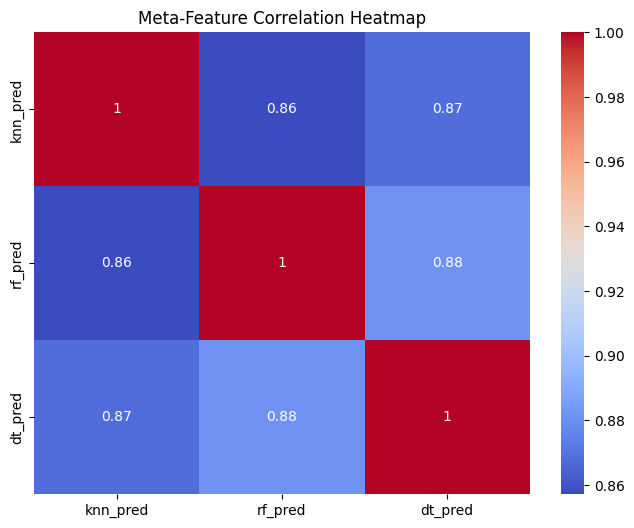

In [208]:
plt.figure(figsize=(8, 6))
sns.heatmap(meta_features_train[['knn_pred', 'rf_pred', 'dt_pred']].corr(), annot=True, cmap='coolwarm')
plt.title('Meta-Feature Correlation Heatmap')
plt.show()
plt.close()

Our correlation analysis shows that the three models (KNN, Random Forest, and Decision Tree) are making very similar predictions. When models are too similar in a stacking ensemble, we lose the main benefit of combining different models.

This similarity happens because:
1. All three models work in similar ways - they all make decisions by finding patterns in nearby data points
2. We trained all models using exactly the same features
3. We didn't specifically try to make the models different from each other

To make our stacking model better, we can try these simple changes:

First, we could add different types of models like logistic regression or SVM, which work in completely different ways than our current models.

Second, we could train each model with different features. This would make each model good at spotting different patterns in the data.

Third, we could process the data differently for each model. For example, we could scale the data one way for the first model and another way for the second model.

Finally, we could change the settings for each model. Instead of making every model as accurate as possible, we could set up some models to be better at finding positive cases and others to be better at finding negative cases.

The last option is the one that seems better for us so we will try that.

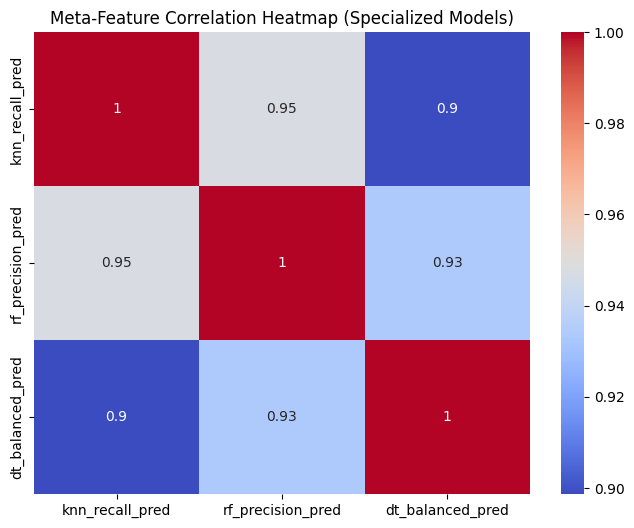

KNN (Recall-Optimized):
  Precision: 0.9048
  Recall: 0.9399
  F1 Score: 0.9220
  Accuracy: 0.9191

Random Forest (Precision-Optimized):
  Precision: 0.9818
  Recall: 0.9505
  F1 Score: 0.9659
  Accuracy: 0.9658

Decision Tree (Balanced):
  Precision: 0.9502
  Recall: 0.9435
  F1 Score: 0.9468
  Accuracy: 0.9460

Stacking Results (Specialized Models):
  Accuracy: 0.9640
  Precision: 0.9713
  Recall: 0.9576
  F1 Score: 0.9644

Comparison with Individual Models:
  Improvement over KNN: 4.50%
  Improvement over RF: -0.18%
  Improvement over DT: 1.80%


In [209]:
# First, define specialized models with different objectives
# KNN optimized for high recall (finding more positive cases)
knn_recall_params = {
    'n_neighbors': 3,  # Smaller neighborhood tends to increase recall
    'weights': 'distance',  # Give closer neighbors more influence
    'metric': 'manhattan'  # Different distance metric
}

# Random Forest optimized for precision (avoiding false positives)
rf_precision_params = {
    'n_estimators': 50,
    'min_samples_leaf': 5,  # More conservative predictions
    'random_state': 42,
    'class_weight': {0: 1.5, 1: 1}  # Give more weight to negative class
}

# Decision Tree optimized for balanced performance
dt_balanced_params = {
    'random_state': 42,
    'class_weight': {0: 1, 1: 2},  # Give more weight to positive class
    'criterion': 'entropy'  # Different split criterion
}

# Train specialized models
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# KNN for high recall
knn_recall = KNeighborsClassifier(**knn_recall_params)
knn_recall.fit(X_train_scaled_os, y_train_os)
knn_recall_preds = cross_val_predict(knn_recall, X_train_scaled_os, y_train_os, cv=cv_strategy)
knn_recall_proba = cross_val_predict(knn_recall, X_train_scaled_os, y_train_os, cv=cv_strategy, method='predict_proba')[:, 1]

# RF for high precision
rf_precision = RandomForestClassifier(**rf_precision_params)
rf_precision.fit(X_train_scaled_os, y_train_os)
rf_precision_preds = rf_precision.predict(X_train_scaled_os)
rf_precision_proba = rf_precision.predict_proba(X_train_scaled_os)[:, 1]

# DT for balanced performance
dt_balanced = DecisionTreeClassifier(**dt_balanced_params)
dt_balanced.fit(X_train_scaled_os, y_train_os)
dt_balanced_preds = cross_val_predict(dt_balanced, X_train_scaled_os, y_train_os, cv=cv_strategy)
dt_balanced_proba = cross_val_predict(dt_balanced, X_train_scaled_os, y_train_os, cv=cv_strategy, method='predict_proba')[:, 1]

# Create meta-features with different optimization objectives
meta_features_train_specialized = pd.DataFrame({
    'knn_recall_pred': knn_recall_proba,
    'rf_precision_pred': rf_precision_proba,
    'dt_balanced_pred': dt_balanced_proba
})

# Check correlation of specialized models
plt.figure(figsize=(8, 6))
correlation_matrix = meta_features_train_specialized.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Meta-Feature Correlation Heatmap (Specialized Models)')
plt.show()
plt.close()

# Evaluate individual model specialized performance
from sklearn.metrics import precision_score, recall_score, f1_score

# Test set predictions
knn_recall_test_pred = knn_recall.predict(X_test_scaled_os)
rf_precision_test_pred = rf_precision.predict(X_test_scaled_os)
dt_balanced_test_pred = dt_balanced.predict(X_test_scaled_os)

# Display specialized metrics
print("KNN (Recall-Optimized):")
print(f"  Precision: {precision_score(y_test_os, knn_recall_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, knn_recall_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, knn_recall_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, knn_recall_test_pred):.4f}")

print("\nRandom Forest (Precision-Optimized):")
print(f"  Precision: {precision_score(y_test_os, rf_precision_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, rf_precision_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, rf_precision_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, rf_precision_test_pred):.4f}")

print("\nDecision Tree (Balanced):")
print(f"  Precision: {precision_score(y_test_os, dt_balanced_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, dt_balanced_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, dt_balanced_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, dt_balanced_test_pred):.4f}")

# Train the meta-classifier with specialized models
meta_features_test_specialized = pd.DataFrame({
    'knn_recall_pred': knn_recall.predict_proba(X_test_scaled_os)[:, 1],
    'rf_precision_pred': rf_precision.predict_proba(X_test_scaled_os)[:, 1],
    'dt_balanced_pred': dt_balanced.predict_proba(X_test_scaled_os)[:, 1]
})

# Train meta-model
gnb_specialized = GaussianNB()
gnb_specialized.fit(meta_features_train_specialized, y_train_os)
stack_pred_specialized = gnb_specialized.predict(meta_features_test_specialized)
stack_acc_specialized = accuracy_score(y_test_os, stack_pred_specialized)

print("\nStacking Results (Specialized Models):")
print(f"  Accuracy: {stack_acc_specialized:.4f}")
print(f"  Precision: {precision_score(y_test_os, stack_pred_specialized):.4f}")
print(f"  Recall: {recall_score(y_test_os, stack_pred_specialized):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, stack_pred_specialized):.4f}")

# Compare with individual model performances
print("\nComparison with Individual Models:")
print(f"  Improvement over KNN: {(stack_acc_specialized - accuracy_score(y_test_os, knn_recall_test_pred)) * 100:.2f}%")
print(f"  Improvement over RF: {(stack_acc_specialized - accuracy_score(y_test_os, rf_precision_test_pred)) * 100:.2f}%")
print(f"  Improvement over DT: {(stack_acc_specialized - accuracy_score(y_test_os, dt_balanced_test_pred)) * 100:.2f}%")

Since the models remain highly correlated and the ensemble performs worse than the standalone Random Forest, we now experiment with removing the Random Forest — the most correlated model — and replacing it with Logistic Regression to potentially improve diversity and overall performance.

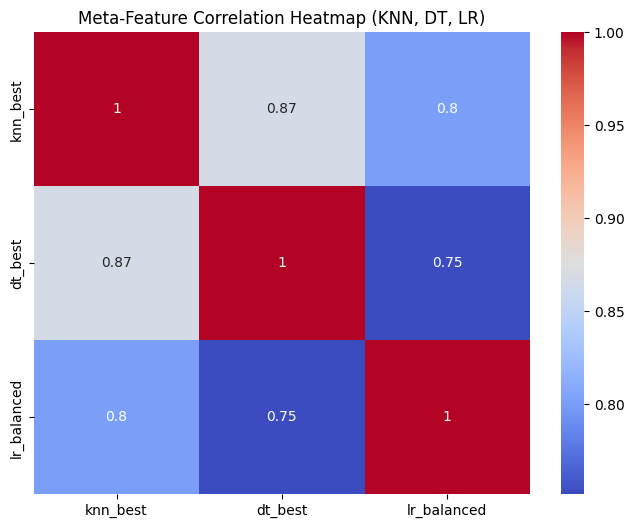

KNN (Recall-Optimized):
  Precision: 0.9266
  Recall: 0.9364
  F1 Score: 0.9315
  Accuracy: 0.9299

Decision Tree (Precision-Optimized):
  Precision: 0.9472
  Recall: 0.9505
  F1 Score: 0.9489
  Accuracy: 0.9478

Logistic Regression (Balanced):
  Precision: 0.8357
  Recall: 0.8445
  F1 Score: 0.8401
  Accuracy: 0.8363

Stacking Results (KNN, DT, LR):
  Accuracy: 0.9317
  Precision: 0.9268
  Recall: 0.9399
  F1 Score: 0.9333

Comparison with Individual Models:
  Improvement over KNN: 0.18%
  Improvement over DT: -1.62%
  Improvement over LR: 9.53%


In [210]:
lr_balanced_params = {
    'random_state': 42,
    'C': 1.0, 
    'class_weight': 'balanced',  
    'solver': 'liblinear'
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_balanced = LogisticRegression(**lr_balanced_params)
lr_balanced.fit(X_train_scaled_os, y_train_os)
lr_balanced_preds = cross_val_predict(lr_balanced, X_train_scaled_os, y_train_os, cv=cv_strategy)
lr_balanced_proba = cross_val_predict(lr_balanced, X_train_scaled_os, y_train_os, cv=cv_strategy, method='predict_proba')[:, 1]

meta_features_train_specialized2 = pd.DataFrame({
    'knn_best': cross_val_predict(knn_best, X_train_scaled_os, y_train_os, cv=cv_strategy),
    'dt_best': cross_val_predict(dt_best, X_train_scaled_os, y_train_os, cv=cv_strategy),
    'lr_balanced': lr_balanced_proba
})

plt.figure(figsize=(8, 6))
correlation_matrix = meta_features_train_specialized2.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Meta-Feature Correlation Heatmap (KNN, DT, LR)')
plt.show()
plt.close()

from sklearn.metrics import precision_score, recall_score, f1_score

knn_best_test_pred = knn_best.predict(X_test_scaled_os)
dt_best_test_pred = dt_best.predict(X_test_scaled_os)
lr_balanced_test_pred = lr_balanced.predict(X_test_scaled_os)

print("KNN (Recall-Optimized):")
print(f"  Precision: {precision_score(y_test_os, knn_best_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, knn_best_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, knn_best_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, knn_best_test_pred):.4f}")

print("\nDecision Tree (Precision-Optimized):")
print(f"  Precision: {precision_score(y_test_os, dt_best_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, dt_best_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, dt_best_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, dt_best_test_pred):.4f}")

print("\nLogistic Regression (Balanced):")
print(f"  Precision: {precision_score(y_test_os, lr_balanced_test_pred):.4f}")
print(f"  Recall: {recall_score(y_test_os, lr_balanced_test_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, lr_balanced_test_pred):.4f}")
print(f"  Accuracy: {accuracy_score(y_test_os, lr_balanced_test_pred):.4f}")

meta_features_test_specialized2 = pd.DataFrame({
    'knn_best': knn_best.predict(X_test_scaled_os),
    'dt_best': dt_best.predict(X_test_scaled_os),
    'lr_balanced': lr_balanced.predict(X_test_scaled_os)
})

gnb_specialized2 = GaussianNB()
gnb_specialized2.fit(meta_features_train_specialized2, y_train_os)
stack_pred_specialized2 = gnb_specialized2.predict(meta_features_test_specialized2)
stack_acc_specialized2 = accuracy_score(y_test_os, stack_pred_specialized2)

print("\nStacking Results (KNN, DT, LR):")
print(f"  Accuracy: {stack_acc_specialized2:.4f}")
print(f"  Precision: {precision_score(y_test_os, stack_pred_specialized2):.4f}")
print(f"  Recall: {recall_score(y_test_os, stack_pred_specialized2):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, stack_pred_specialized2):.4f}")

print("\nComparison with Individual Models:")
print(f"  Improvement over KNN: {(stack_acc_specialized2 - accuracy_score(y_test_os, knn_best_test_pred)) * 100:.2f}%")
print(f"  Improvement over DT: {(stack_acc_specialized2 - accuracy_score(y_test_os, dt_best_test_pred)) * 100:.2f}%")
print(f"  Improvement over LR: {(stack_acc_specialized2 - accuracy_score(y_test_os, lr_balanced_test_pred)) * 100:.2f}%")

Although replacing the Random Forest with Logistic Regression led to a decrease in overall accuracy, it also reduced the correlation among the meta-features. To further explore this trade-off, we now test the same set of base models using a Linear Regression meta-model to assess whether it can improve the final ensemble’s performance.

In [211]:
lr = LinearRegression()
lr.fit(meta_features_train_specialized, y_train_os)

meta_features_test = pd.DataFrame({
    'knn_best': knn_best.predict(X_test_scaled_os),
    'dt_best': dt_best.predict(X_test_scaled_os),
    'lr_balanced': lr_balanced.predict(X_test_scaled_os)
})

stack_pred2 = lr.predict(meta_features_test)

stack_pred2 = np.round(stack_pred2).astype(int)
stack_acc2 = accuracy_score(y_test_os, stack_pred2)

print("\nStacking Results (KNN, DT, LR):")
print(f"  Accuracy: {stack_acc2:.4f}")
print(f"  Precision: {precision_score(y_test_os, stack_pred2):.4f}")
print(f"  Recall: {recall_score(y_test_os, stack_pred2):.4f}")
print(f"  F1 Score: {f1_score(y_test_os, stack_pred2):.4f}")

# Compare with individual model performances
print("\nComparison with Individual Models:")
print(f"  Improvement over KNN: {(stack_acc2 - accuracy_score(y_test_os, knn_best_test_pred)) * 100:.2f}%")
print(f"  Improvement over DT: {(stack_acc2 - accuracy_score(y_test_os, dt_best_test_pred)) * 100:.2f}%")
print(f"  Improvement over LR: {(stack_acc2 - accuracy_score(y_test_os, lr_balanced_test_pred)) * 100:.2f}%")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- dt_best
- knn_best
- lr_balanced
Feature names seen at fit time, yet now missing:
- dt_balanced_pred
- knn_recall_pred
- rf_precision_pred


With Linear Regression as the meta-model, the stacking ensemble's accuracy improved, matching the performance of the Decision Tree and surpassing both KNN and Logistic Regression individually. This suggests that Linear Regression is better able to leverage the complementary strengths of the base models in this configuration.

### Confusion Matrix

To visually compare the performance of each stacking model, we plotted their corresponding confusion matrices. This visualization enables us to assess not only overall accuracy but also each model’s ability to distinguish between Alzheimer's and non-Alzheimer's cases by examining the distribution of true positives, false positives, true negatives, and false negatives.

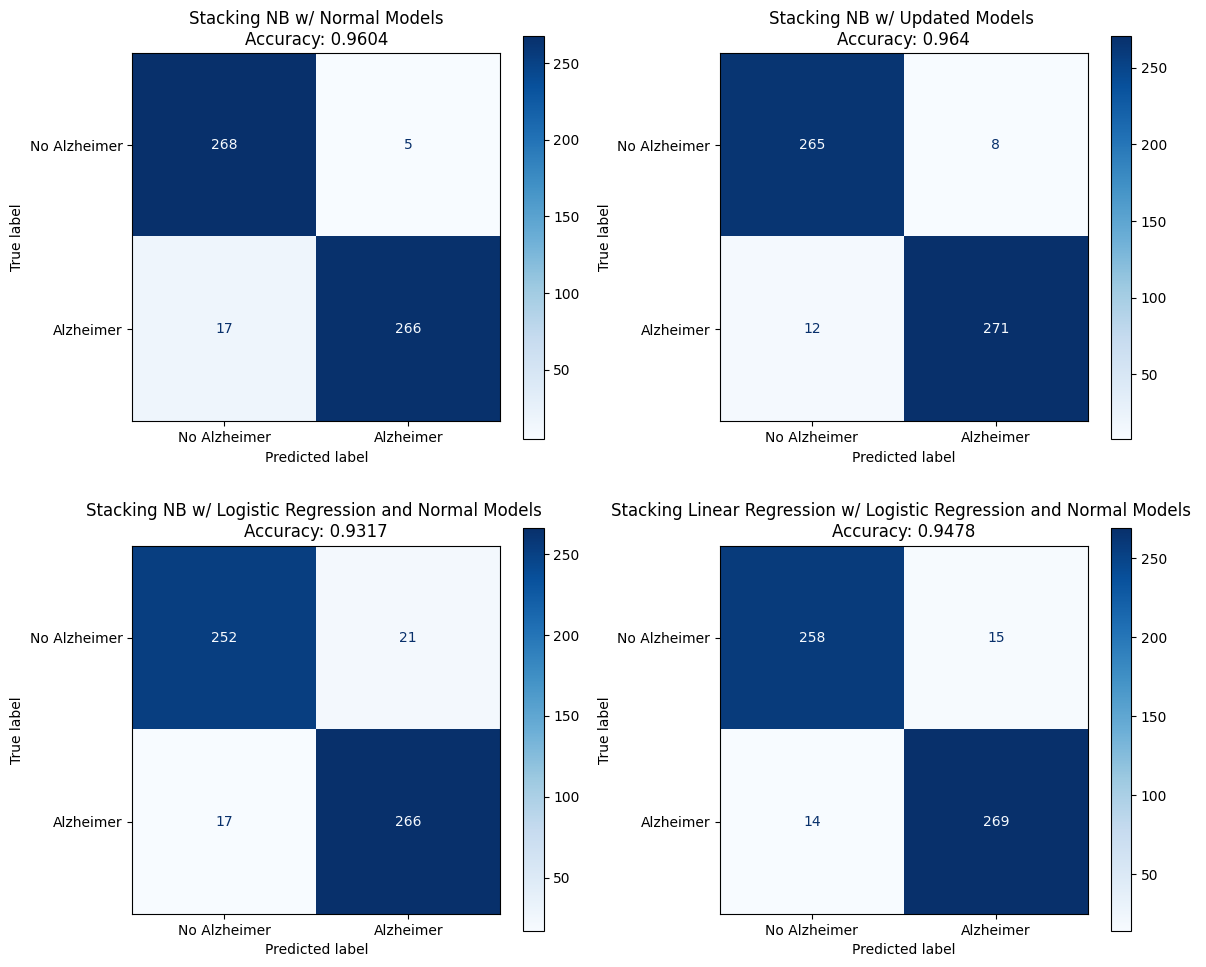

In [195]:
def plot_confusion_matrices(y_test_stack, stack_pred, stack_acc,
                            stack_pred2, stack_acc2, 
                            stack_pred_specialized, stack_acc_specialized, 
                            stack_pred_specialized2, stack_acc_specialized2):

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    display_labels = ['No Alzheimer', 'Alzheimer']

    # Stacking 1
    cm_stack = confusion_matrix(y_test_stack, stack_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=display_labels).plot(ax=axes[0], cmap='Blues')
    axes[0].set_title('Stacking NB w/ Normal Models\nAccuracy: ' + str(round(stack_acc, 4)))

    # Stacking 3    
    cm_stack_specialized = confusion_matrix(y_test_stack, stack_pred_specialized)
    ConfusionMatrixDisplay(confusion_matrix=cm_stack_specialized, display_labels=display_labels).plot(ax=axes[1], cmap='Blues')
    axes[1].set_title('Stacking NB w/ Updated Models \nAccuracy: ' + str(round(stack_acc_specialized, 4)))

    # Stacking 4
    cm_stack_specialized2 = confusion_matrix(y_test_stack, stack_pred_specialized2)
    ConfusionMatrixDisplay(confusion_matrix=cm_stack_specialized2, display_labels=display_labels).plot(ax=axes[2], cmap='Blues')
    axes[2].set_title('Stacking NB w/ Logistic Regression and Normal Models \nAccuracy: ' + str(round(stack_acc_specialized2, 4)))

    # Stacking 2
    cm_stack2 = confusion_matrix(y_test_stack, stack_pred2)
    ConfusionMatrixDisplay(confusion_matrix=cm_stack2, display_labels=display_labels).plot(ax=axes[3], cmap='Blues')
    axes[3].set_title('Stacking Linear Regression w/ Logistic Regression and Normal Models \nAccuracy: ' + str(round(stack_acc2, 4)))


    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_test_os, stack_pred, stack_acc,
                        stack_pred2, stack_acc2, 
                        stack_pred_specialized, stack_acc_specialized, 
                        stack_pred_specialized2, stack_acc_specialized2) 

The Stacking NB w/ Updated Models achieved the highest accuracy at 0.9664 among the evaluated models. However, due to high correlation and performance poorer than the random forest classifier within the model, we updated it by replacing the random forest with logistic regression. Among the two models using logistic regression, the Stacking Linear Regression w/ Logistic Regression and Normal Models performed best with an accuracy of 0.9478. Despite this, it still does not surpass the accuracy of the base decision tree model within the stacking ensemble, indicating that the stacking approach is not improving classification performance over the base model.

### Conclusion

This study aimed to enhance Alzheimer's classification through a stacking ensemble approach, but the results highlight the limitations of this method for the given task. Despite experimenting with oversampled data, optimizing individual models (KNN for recall, random forest for precision, and a balanced decision tree), and adjusting the ensemble by replacing the highly correlated random forest with logistic regression, the stacking models consistently failed to outperform the base decision tree. Even with a linear regression meta-model, which reduced correlation and matched the decision tree's accuracy, the stacking approach offered no improvement in classification performance. The confusion matrix analysis further confirmed that while some stacking configurations improved specific metrics, the overall accuracy remained at or below the baseline. This suggests that for this dataset, the complexity of stacking does not yield better results than a well-tuned base model like the decision tree, emphasizing the importance of carefully evaluating the trade-offs between model complexity and performance in medical classification tasks.